### TYK2 DMS/FlowDMS Global Rescaling

For BMS, we want to convert both the DMS and FlowDMS data to a 0-1 scale for interpretation individually, as well as for comparison on a "common" scale. For DMS, we use the normalized summary statistics from run 7, IFN-alpha 100 U/mL minus Untreated. For FlowDMS, we use the most recent midpoints computed from run 2. These formatted TSVs are located [here](../sumstats/BMS). We can make a simple plot of the relationship between the two derived scores across all variants:

In [18]:
library(ggpubr)
library(scales)
library(scico)
library(tidyverse)

source("../src/dms-analysis-utils.R")

In [3]:
midpoints <- read_tsv("/home/rstudio/bms-dms/sumstats/TYK2-VAMP/run2B/OCNT-VAMPLIB-1-assay-run2B-vampseq-midpoints.sumstats.tsv") %>%
    mutate(mut_aa = if_else(mut_aa == "X", "*", mut_aa),
           chunk = as.numeric(gsub("rc", "", chunk)))

dms <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")  %>%
    mutate(aa = if_else(aa == "X", "*", aa),
           chunk = as.numeric(gsub("rc", "", chunk))) %>%
    filter(condition == "IFNalpha100_0 - None_0") %>%
    dplyr::select(chunk, pos, aa, estimate, std.error, statistic, p.value, p.adj) %>%
    mutate(fc = 2^estimate,
           fc_lci = 2^(estimate - 2*std.error),
           fc_uci = 2^(estimate + 2*std.error))

joined_unscaled <- inner_join(dms %>%
                                  select(chunk, pos, aa, estimate, p.adj) %>%
                                  rename("DMS_Log2FoldChange" = "estimate",
                                         "DMS_FDR" = "p.adj"),
                              midpoints %>%
                                  select(chunk, pos, mut_aa, estimate, p.adj) %>%
                                  rename("FlowDMS_MidpointShift" = "estimate",
                                         "FlowDMS_FDR" = "p.adj"),
                              by = c("chunk", "pos", "aa" = "mut_aa"))

joined_unscaled %>% write_tsv("../sumstats/DMS7-FLOW2-join.tsv")
joined_unscaled %>%
    filter(DMS_FDR < 0.05,
           DMS_Log2FoldChange < 0,
           (FlowDMS_FDR > 0.1 | FlowDMS_MidpointShift > 0)) %>%
    write_tsv("../sumstats/DMS7-FLOW2-join-subset.tsv")

Rows: 23718 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


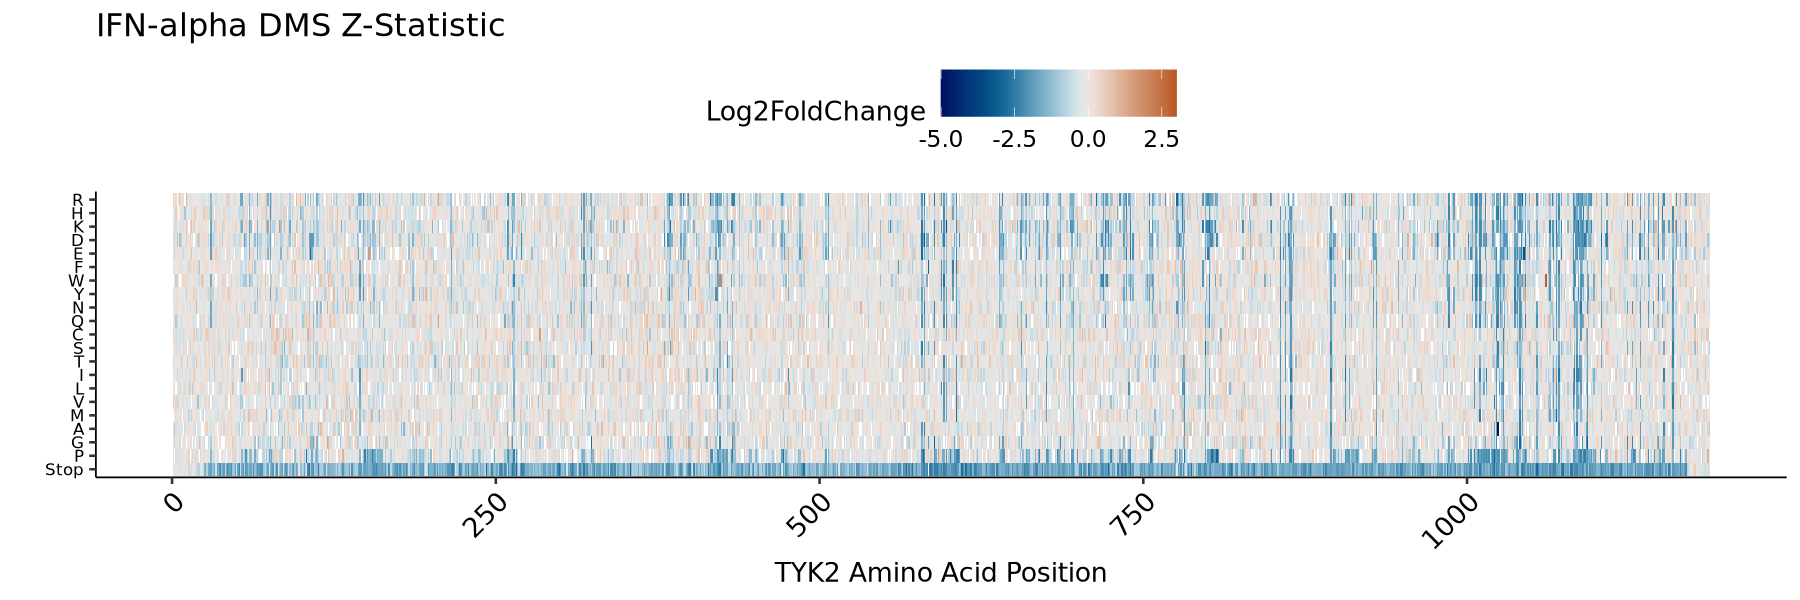

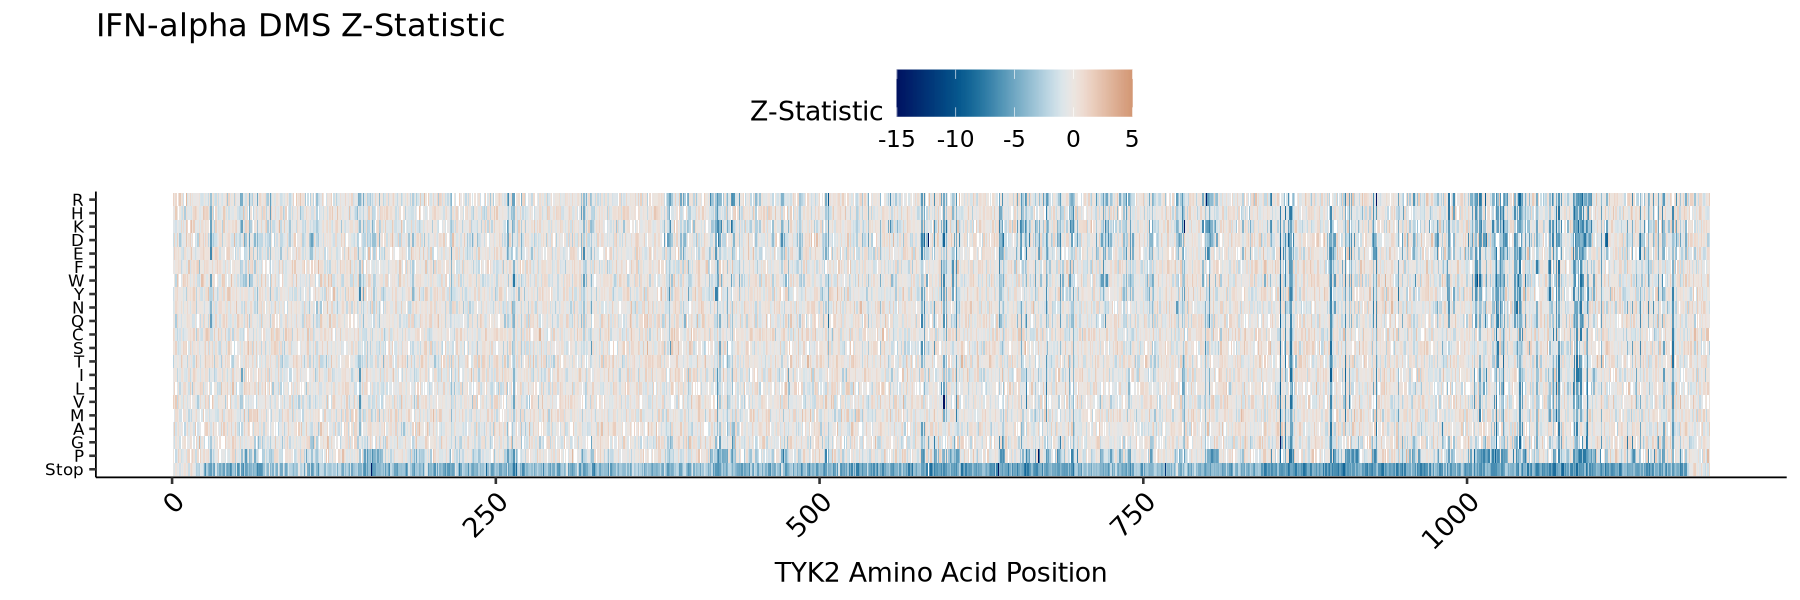

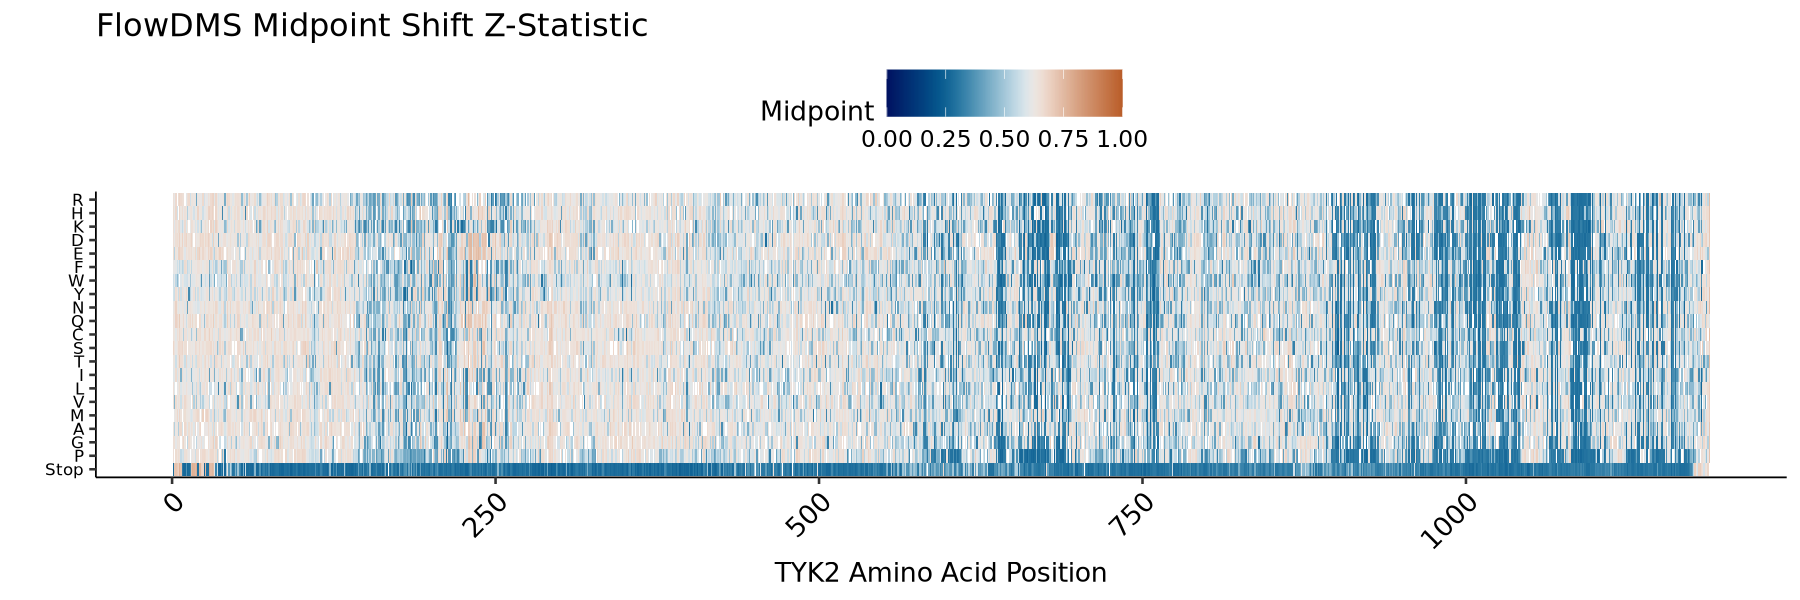

png 
  2

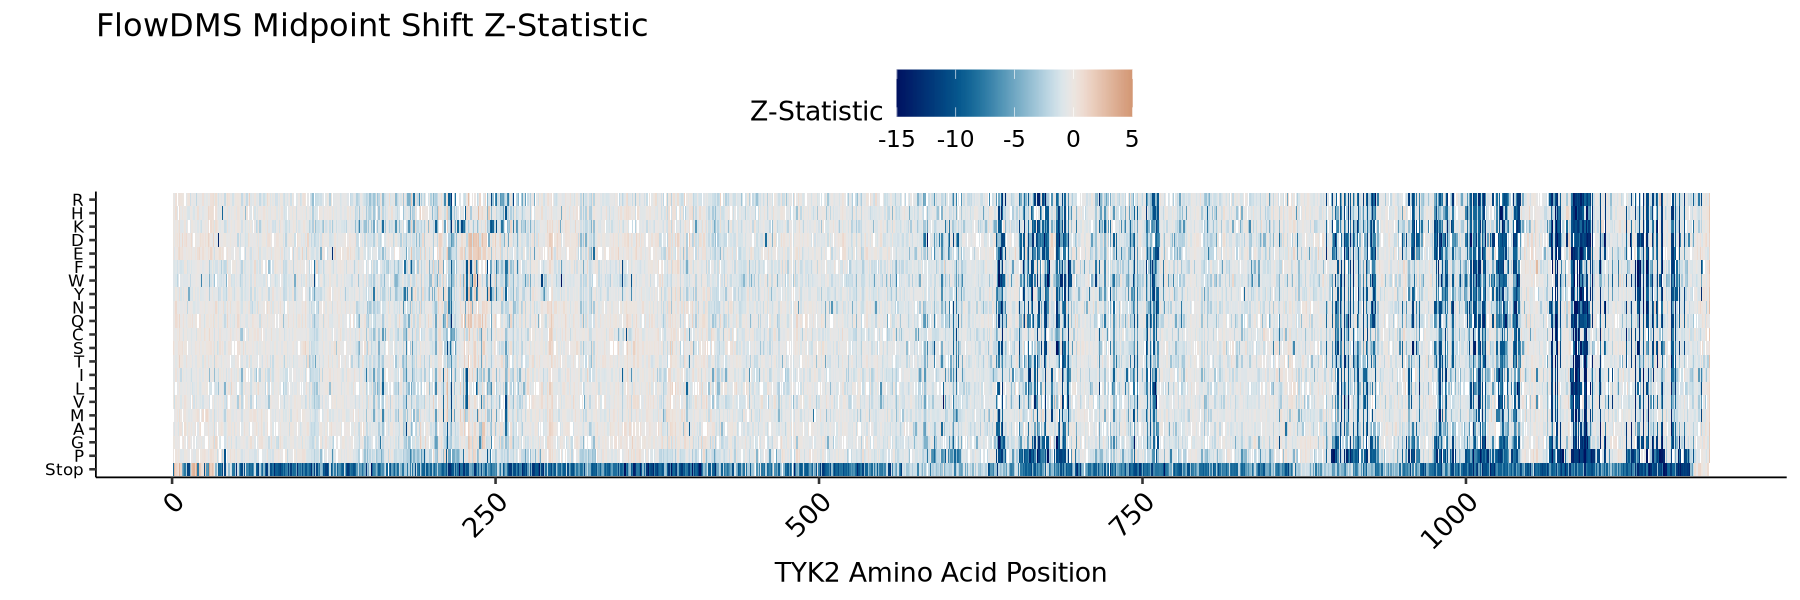

In [51]:
dms_for_plotting <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")  %>%
    mutate(aa = if_else(aa == "X", "*", aa),
           chunk = as.numeric(gsub("rc", "", chunk))) %>%
    filter(condition == "IFNalpha100_0 - None_0") %>%
    dplyr::select(chunk, pos, aa, estimate, std.error, statistic, p.value, p.adj)

ifna_plot_l2fc <- dms_for_plotting %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    mutate(aa = factor(aa, levels = c("R","H","K","D","E",
                                      "F","W","Y","N","Q",
                                      "C","S","T","I","L",
                                      "V","M","A","G","P","Stop"))) %>%
    rename("Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = Log2FoldChange)) +
            scale_fill_scico_mid( limits = c(-5, 3), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 10)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("IFN-alpha DMS Z-Statistic")

flow_plot_mid <- midpoints  %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    mutate(mut_aa = factor(mut_aa, levels = c("R","H","K","D","E",
                                      "F","W","Y","N","Q",
                                      "C","S","T","I","L",
                                      "V","M","A","G","P","Stop"))) %>%
    rename("Midpoint" = "score_mean") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = Midpoint)) +
            scale_fill_scico_mid( limits = c(0, 1), palette = "vik", mid = 0.63, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 10)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("FlowDMS Midpoint Shift Z-Statistic")

ifna_plot_z <- dms_for_plotting %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    mutate(aa = factor(aa, levels = c("R","H","K","D","E",
                                      "F","W","Y","N","Q",
                                      "C","S","T","I","L",
                                      "V","M","A","G","P","Stop"))) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 10)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("IFN-alpha DMS Z-Statistic")

flow_plot_z <- midpoints  %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    mutate(mut_aa = factor(mut_aa, levels = c("R","H","K","D","E",
                                      "F","W","Y","N","Q",
                                      "C","S","T","I","L",
                                      "V","M","A","G","P","Stop"))) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 10)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("FlowDMS Midpoint Shift Z-Statistic")

options(repr.plot.width = 15, repr.plot.height = 5)
ifna_plot_l2fc
ifna_plot_z
flow_plot_mid
flow_plot_z

pdf("../dataviz/TYK2/DMS7-FLOW2-HEATMAPS.pdf", width = 15, height = 5)
ifna_plot_l2fc
ifna_plot_z
flow_plot_mid
flow_plot_z
dev.off()

In [9]:
joined_unscaled_poscount <- joined_unscaled %>%
    filter(DMS_FDR < 0.05,
           DMS_Log2FoldChange < 0,
           (FlowDMS_FDR > 0.1 | FlowDMS_MidpointShift > 0)) %>%
    count(pos)

joined_unscaled_poscount %>% write_tsv("../sumstats/DMS7-FLOW2-join-subset-poscount.tsv")

poscount_plot <- joined_unscaled_poscount %>%
    ggplot() +
        geom_bar(aes(x = pos, y = n), stat = "identity", color = "#336699") +
        theme_pubr(base_size = 20)

ggsave("../dataviz/TYK2/DMS7-FLOW2-poscount.pdf",
       poscount_plot,
       width = 15, height = 6)

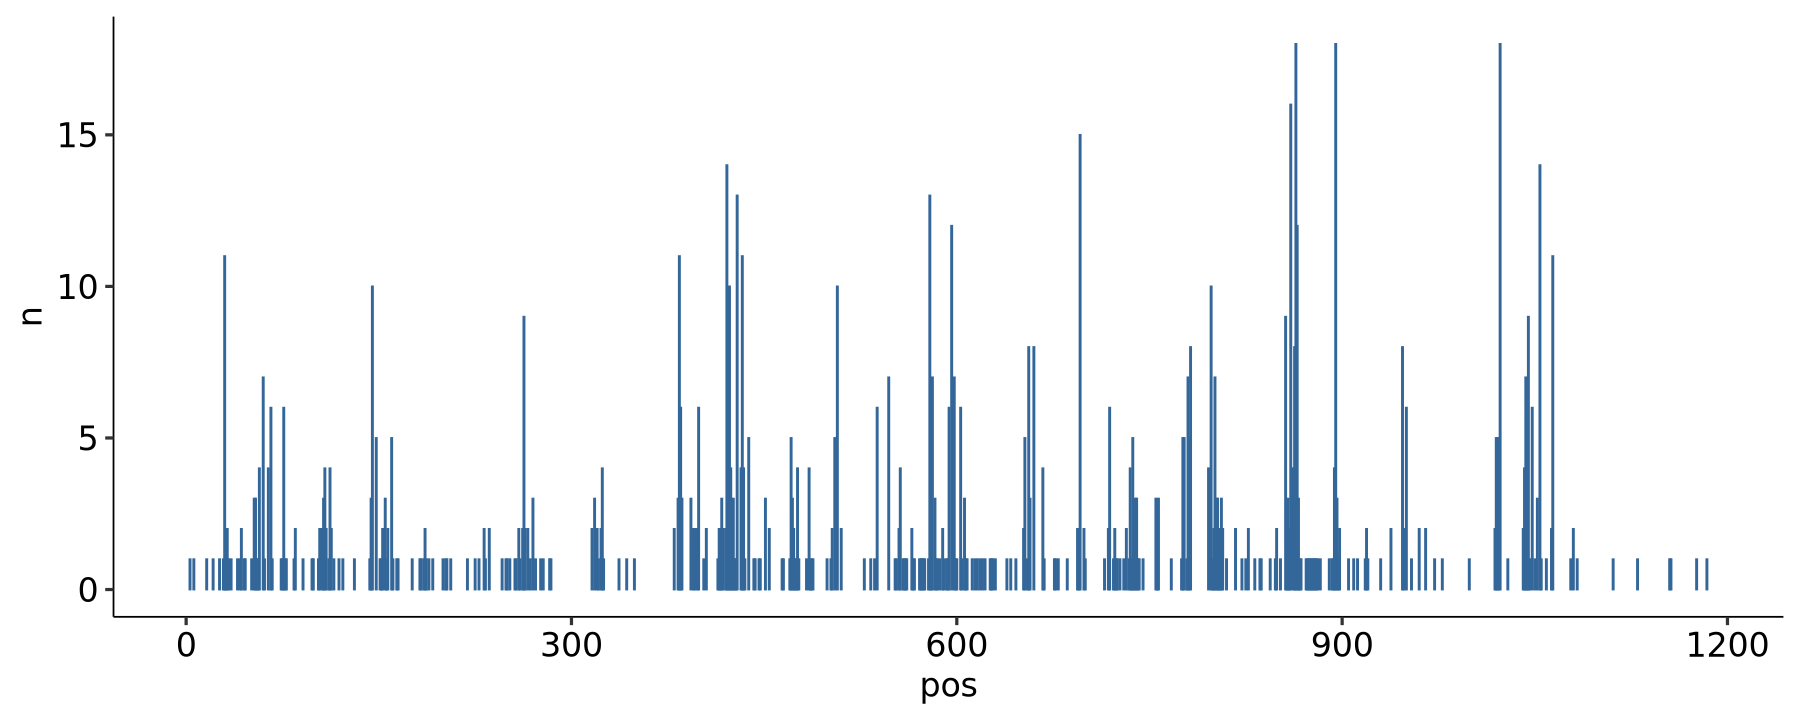

In [10]:
options(repr.plot.width = 15, repr.plot.height = 6)
poscount_plot

In [5]:
stop_scores <- midpoints %>%
    filter(mut_aa %in% c("X","*")) %>%
    group_by(chunk) %>%
    summarize("Stop score" = median(score_mean, na.rm = TRUE),
              "Stop score standard error" = median(score_se, na.rm = TRUE))

sample_stats_rescale <- midpoints %>%
    filter(mut_aa != "WT") %>%
    left_join(stop_scores, by = "chunk") %>%
    mutate(estimate = (score_mean - `Stop score`)/(`WT score` - `Stop score`),
           std.error = score_se/(`WT score` - `Stop score`))

flowdms_format <- sample_stats_rescale %>%
    select(chunk, pos, mut_aa, score_mean, score_se, estimate, std.error) %>%
    mutate("Midpoint_Lower" = score_mean - 2*score_se,
           "Midpoint_Upper" = score_mean - 2*score_se,
           "ScaledScore_Lower" = estimate - 2*std.error,
           "ScaledScore_Upper" = estimate + 2*std.error) %>%
    select(-std.error, -score_se) %>%
    rename("Chunk" = "chunk",
           "Position" = "pos",
           "AA" = "mut_aa",
           "Midpoint" = "score_mean",
           "ScaledScore" = "estimate") %>%
    relocate("ScaledScore", .after = "Midpoint_Upper") %>%
    arrange(Position, AA)

write_tsv(flowdms_format, "../sumstats/BMS/BMS-2/ExpressionDMS_midpoints_rescaled.tsv")

In [6]:
stop_scores_dms <- dms %>%
    filter(aa == "*") %>% 
    group_by(chunk) %>%
    summarize(stop_med = median(fc))

dms_rescale <- dms %>%
    left_join(stop_scores_dms, by = "chunk") %>%
    mutate(fc_rescale = (fc - stop_med)/(1 - stop_med),
           fc_lci_rescale = (fc_lci - stop_med)/(1 - stop_med),
           fc_uci_rescale = (fc_uci - stop_med)/(1 - stop_med))

dms_format <- dms_rescale %>%
    select(chunk, pos, aa, estimate, std.error, p.adj, fc_rescale, fc_lci_rescale, fc_uci_rescale) %>%
    rename("Chunk" = "chunk",
            "Position" = "pos",
            "AA" = "aa",
            "Log2FoldChange" = "estimate",
            "Log2FoldChangeError" = "std.error",
            "FDR" = "p.adj",
            "ScaledScore" = "fc_rescale",
            "ScaledScore_Lower" = "fc_lci_rescale",
            "ScaledScore_Upper" = "fc_uci_rescale") %>%
    arrange(Position, AA)


write_tsv(dms_format, "../sumstats/BMS/BMS-2/DMS_IFNalpha100vsUntreated_rescaled.tsv")

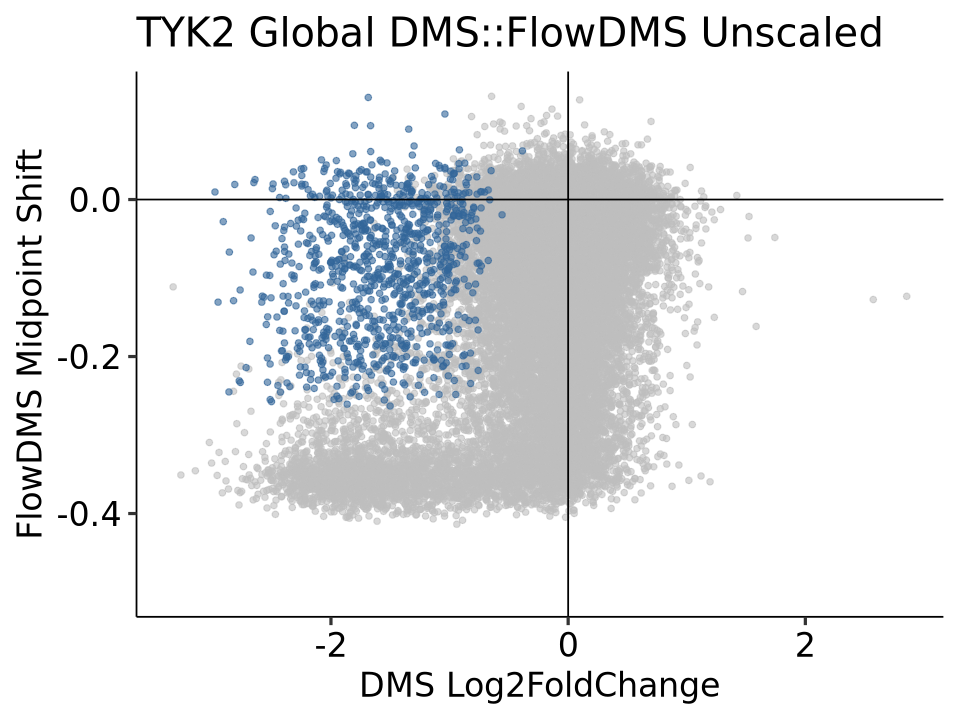

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)
plot_data <- joined_unscaled %>%
    mutate(group = if_else(DMS_FDR < 0.05 &
                           DMS_Log2FoldChange < 0 &
                           (FlowDMS_FDR > 0.1 | FlowDMS_MidpointShift > 0), "#336699", "gray"))

scatter_plot <- ggplot() +
    geom_point(data = plot_data %>% filter(group == "gray"),
               aes(x = DMS_Log2FoldChange,
                   y = FlowDMS_MidpointShift,
                   color = group),
               alpha = 0.6,
               size = 1.5) +
    geom_point(data = plot_data %>% filter(group != "gray"),
               aes(x = DMS_Log2FoldChange,
                   y = FlowDMS_MidpointShift,
                   color = group),
               alpha = 0.6,
               size = 1.5) +
    coord_cartesian(ylim = c(-0.5, NA)) +
    theme_pubr(base_size = 20) +
    xlab("DMS Log2FoldChange") +
    ylab("FlowDMS Midpoint Shift") +
    scale_color_identity() +
    ggtitle("TYK2 Global DMS::FlowDMS Unscaled") +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0)

scatter_plot
ggsave("../dataviz/TYK2/DMS7-FLOW2-scatter.pdf",
       scatter_plot,
       width = 8,
       height = 6)
ggsave("../dataviz/TYK2/DMS7-FLOW2-scatter.jpeg",
       scatter_plot,
       width = 8,
       height = 6)

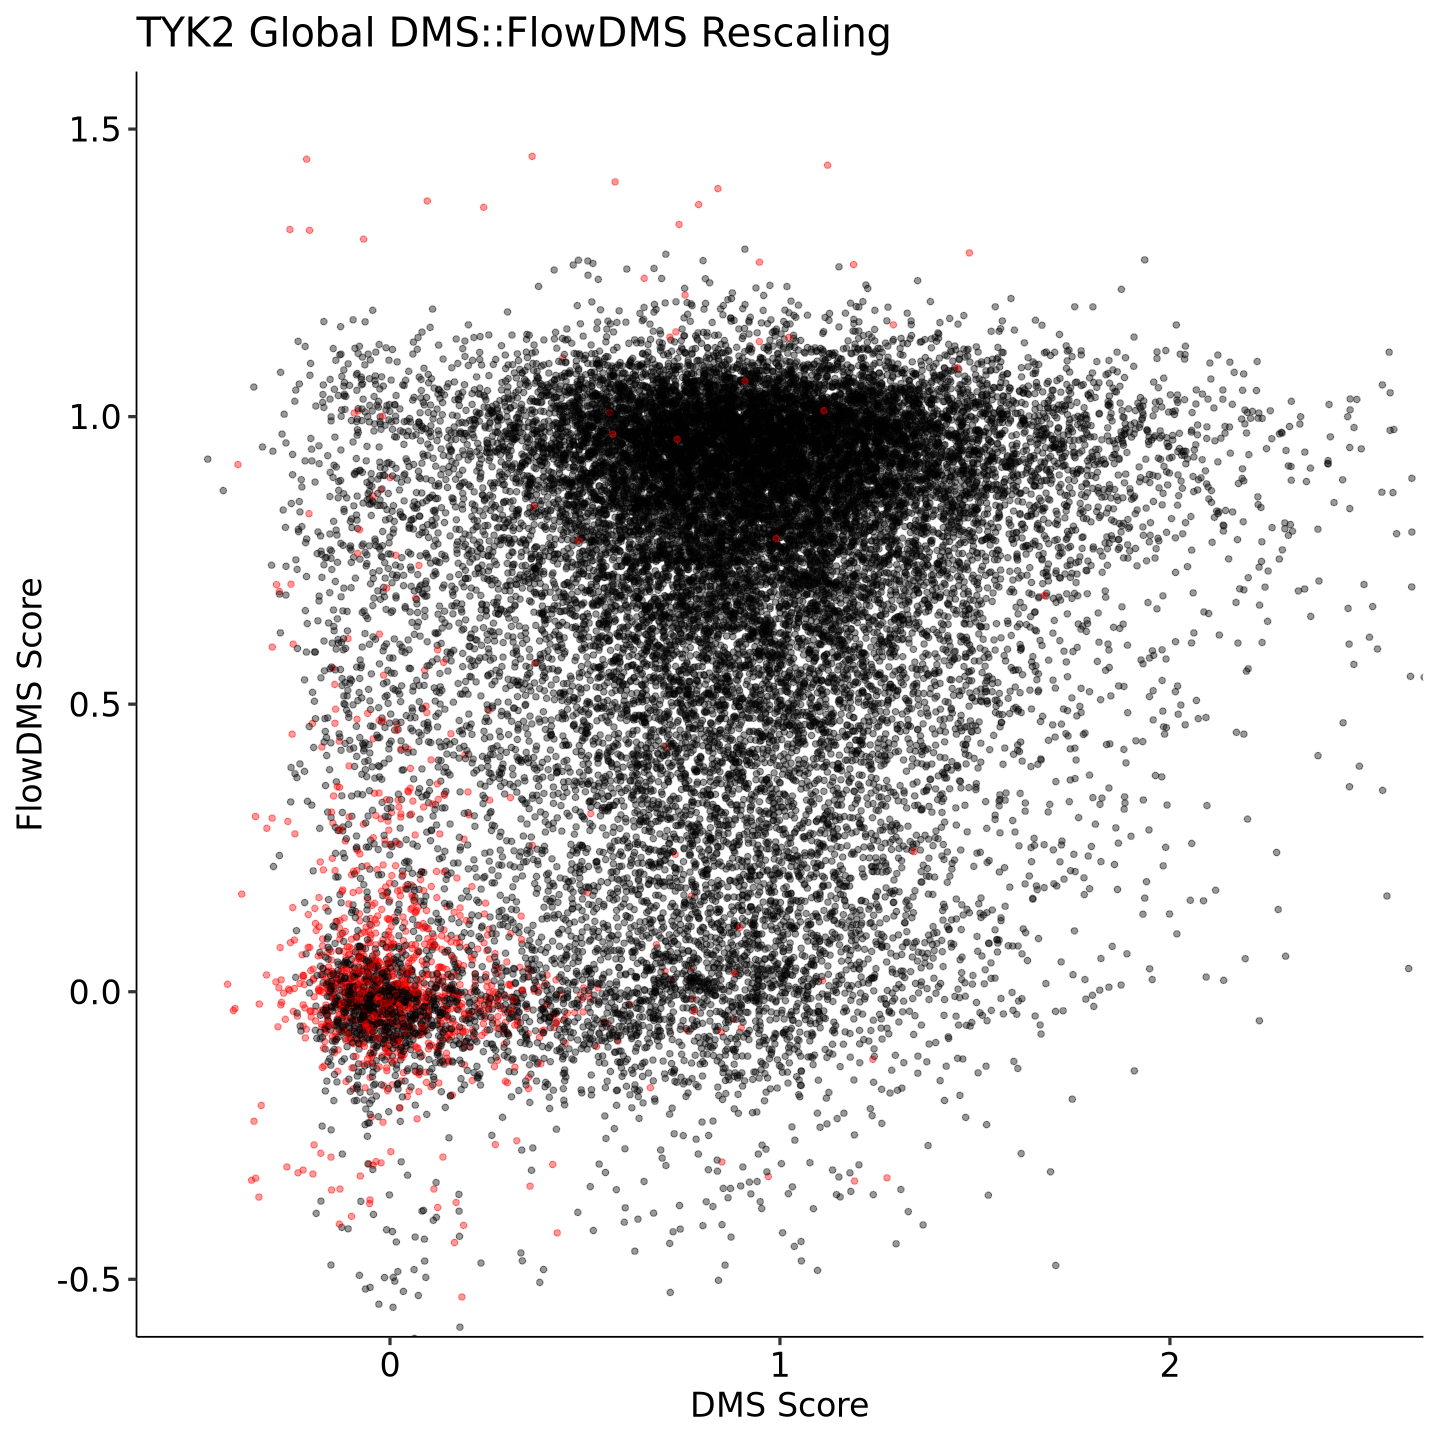

In [8]:
options(repr.plot.width = 12, repr.plot.height = 12)
inner_join(dms_format, flowdms_format, by = join_by(Chunk, Position, AA)) %>%
    ggplot() +
        geom_point(aes(x = ScaledScore.x,
                       y = ScaledScore.y,
                       color = if_else(AA == "*", "red", "black")),
                   alpha = 0.4) +
        coord_cartesian(xlim = c(-0.5, 2.5),
                        ylim = c(-0.5, 1.5)) +
        theme_pubr(base_size = 20) +
        xlab("DMS Score") +
        ylab("FlowDMS Score") +
        scale_color_identity() +
        ggtitle("TYK2 Global DMS::FlowDMS Rescaling")